# import stuff

In [1]:
%load_ext autoreload
%autoreload 2

# import python stuff
import matplotlib.pyplot as plt
import numpy as np

import scipy
import scipy.special as spe
from scipy import optimize
from scipy.stats import poisson
from qutip import *
import iminuit
import time
import multiprocessing as mp
from platform import python_version
import os

# import my functions
from functionsSqueeze import *
from functions_SpinPhonon import *

# import existing Paula funcitons
from PyModules.analyse_eios import eios_sb
from PyModules.analyse_eios import eios_analyse
from PyModules.analyse_eios import eios_data

print("python version:", python_version())
print("number of CPU's:", mp.cpu_count())

python version: 3.6.9
number of CPU's: 8


# Poisson Fits for two ions

## define poisson fit functions (equivalent funcitons to the ones for one ion in eios_analyse)

In [73]:
def plot_hist_res_2I(hist, mus, pops, maxrange=30):
    xx = np.linspace(0, maxrange, maxrange+1)

    y = pops[0]*poisson.pmf(xx, mus[0]) + pops[1]*poisson.pmf(xx, mus[1]) + pops[2]*poisson.pmf(xx, mus[2])

    plt.hist(hist, bins=range(maxrange), rwidth=0.8, align='left', density=True)
    plt.plot(xx, y/np.sum(y))
    plt.show()

In [56]:
def mLL_2I(data, mu_dd, mu_du, mu_uu, p_dd, p_du, p_uu):
    """returns the negative log likelihood functin of a two-poissonian distribution with:
        means mu1 and mu2
        weights (1-p_up) and fit_p_up
        data: an array filled with random numbers from the two-poissonian distribution
    """
    
    # make sure that p_up \in [0, 1]
#     if not (0<= p_up <= 1):
#         p_up = np.max([p_up, 0])
#         p_up = np.min([p_up, 1])

    return -np.sum(np.log(p_dd/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_dd) + p_du/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_du)
                         + p_uu/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_uu)))

In [57]:
def fit_poisson_hist_2I(hist, lowcount=1., highcount=16.):
    """fits a sum of two two-poissonian distributions (see mLL) to a sample hist
    """
    # if hist is a list of histograms, merge them into one hist
    if len(np.shape(hist)) > 1:
        hist = np.append([],hist)

    def func(mu_dd, mu_du, mu_uu, p_dd, p_du, p_uu):
        return mLL_2I(np.array(hist), mu_dd, mu_du, mu_uu, p_dd, p_du, p_uu)

    m = iminuit.Minuit(func, mu_dd = highcount, mu_du = 0.5*highcount, mu_uu = lowcount, p_dd = 0.3, p_du = 0.4, p_uu = 0.3,
                # initial stepsize
               error_mu_dd = 1., error_mu_du = 0.5, error_mu_uu = 0.1, error_p_dd = 0.05, error_p_du = 0.05, error_p_uu = 0.05,
               errordef = 0.5,
                # bounds
               limit_mu_dd = (0., 50), limit_mu_du = (0., 50), limit_mu_uu = (0., 50.), limit_p_dd=(0.,1.), limit_p_du=(0.,1.), limit_p_uu=(0.,1.))
    m.migrad()
    
    # make sure the probabilities add up to 1
    norm = m.values[3] + m.values[4] + m.values[5]
    
    res = {
        'x': [m.values[0], m.values[1], m.values[2], m.values[3]/norm, m.values[4]/norm, m.values[5]/norm],
        'x_err': [m.errors[0], m.errors[1], m.errors[2], m.errors[3]/norm, m.errors[4]/norm, m.errors[5]/norm]
    }
    return res

In [220]:
# def helper_fit_hist_2I(hist, fit_mu_dd, fit_mu_du, fit_mu_uu):
# #     """fits the weights of a two-poissonian distribution (with fixed means fit_mu1, fit_mu2) to the sample given in hists
# #     returns the weight and its error
# #     """
#     if len(hist) == 0: # make sure the hist is not empty
#         raise ValueError('empty histogram')
#     else:
#         # make a helper function to throw into minuit
#         func = lambda p_dd, p_du, p_uu: mLL_2I(np.array(hist), fit_mu_dd, fit_mu_du, fit_mu_uu, p_dd, p_du, p_uu)
        
#         # make a minuit object
#         m = iminuit.Minuit(func, p_dd = 0.3, p_du = 0.4, p_uu = 0.3,
#                            error_p_dd = 0.05, error_p_du = 0.05, error_p_uu = 0.05, errordef = 0.5,
#                            limit_p_dd=(0.,1.), limit_p_du=(0.,1.), limit_p_uu=(0.,1.))

        
#         # minimize the funciton
#         m.migrad()
#         # return the parameter and error (not sure about second summand, taken from original function in eios)
        
#         # make sure the probabilities add up to 1
#         norm = m.values[0] + m.values[1] + m.values[2]
#         norm_err = np.sqrt(m.errors[0]**2 + m.errors[1]**2 + m.errors[2]**2)
        
# #         err0 = np.sqrt(m.errors[0]**2 + m.values[0]**2/norm**2 * norm_err**2)/norm
# #         err1 = np.sqrt(m.errors[1]**2 + m.values[1]**2/norm**2 * norm_err**2)/norm
# #         err2 = np.sqrt(m.errors[2]**2 + m.values[2]**2/norm**2 * norm_err**2)/norm
#         err0 = m.errors[0]/norm
#         err1 = m.errors[1]/norm
#         err2 = m.errors[2]/norm
        
#         err0 = np.min([err0, np.sqrt(err1**2+err2**2)])
#         err1 = np.min([err1, np.sqrt(err2**2+err0**2)])
#         err2 = np.min([err2, np.sqrt(err0**2+err1**2)])
        
#         return m.values[0]/norm, m.values[1]/norm, m.values[2]/norm, err0, err1, err2

def helper_fit_hist_2I(hist, fit_mu_dd, fit_mu_du, fit_mu_uu):
#     """fits the weights of a two-poissonian distribution (with fixed means fit_mu1, fit_mu2) to the sample given in hists
#     returns the weight and its error
#     """
    if len(hist) == 0: # make sure the hist is not empty
        raise ValueError('empty histogram')
    else:
        # make a helper function to throw into minuit
        func = lambda p_same, p_up: mLL_2I(np.array(hist), fit_mu_dd, fit_mu_du, fit_mu_uu, p_same*(1-p_up), (1-p_same), p_same*p_up)
        
        # make a minuit object
        m = iminuit.Minuit(func, p_same = 0.6, p_up = 0.3,
                           error_p_same = 0.05, error_p_up = 0.05, errordef = 0.5,
                           limit_p_same=(0.,1.), limit_p_up=(0.,1.))

        
        # minimize the funciton
        m.migrad()
        
        
#         print("p_same:", np.round(m.values[0]), "p_up:", np.round(m.values[1]))

        # calculate the populations p_dd, p_du, p_uu
        p_dd, p_du, p_uu = m.values[0]*(1-m.values[1]), (1-m.values[0]), m.values[0]*m.values[1]
        
#         print("p_dd, p_du, p_uu:", np.round([p_dd, p_du, p_uu], 3))
        
        # make sure the probabilities add up to 1
        norm = p_dd + p_du + p_uu
        if np.abs(1-norm) > 0.01:
            print("probabilities not normalized!!!")
        
        # calculate the errors of p_dd, p_du, p_uu
        err0 = np.sqrt((m.errors[0]*(1-m.values[1]))**2 + (m.values[0]*m.errors[1])**2)
        err1 = m.errors[0]
        err2 = np.sqrt((m.errors[0]*m.values[1])**2 + (m.values[0]*m.errors[1])**2)
        
#         err0 = np.min([err0, np.sqrt(err1**2+err2**2)])
#         err1 = np.min([err1, np.sqrt(err2**2+err0**2)])
#         err2 = np.min([err2, np.sqrt(err0**2+err1**2)])
        
        # return the parameter and error
        return p_dd, p_du, p_uu, err0, err1, err2
    

# my function for all hist fits (needs pre fit), from rob
def fit_hist_2I(hists, pre_fit, parallel = True):
    t1 = time.time()
#     """fits the weights of a two-poissonian distribution to the samples given in hists
#     parameters:
#         hists: array of arrays, each one a sample of a two-poissonian distribution
#             should a sample be empty, the corresponding y, y_err are set to nan
#         pre_fit: fit result from a fit on all histograms in hists combined
#             (the expectation values mu1, mu2 are taken and fixed in the fits done here)
#             (scipy optimize result, from fit_poisson_hist or fit_poisson_hist_rob)
#         parallel: bool, default False, if parallel computing should be used (better performance, if the mp module works)
#         remove_nan: bool, default True, sets if nans (from empty lists in hists) should be removed in the output
#     returns y, y_err
#         y: a list of weights for the two-poissonian distribution (weight corresponding to mu2, mu2 > mu1)
#         y_err: errors of the weights
#     """
    
    # take variables from prefit
    fit_mu_1, fit_mu_2, fit_mu_3,_,_,_ = pre_fit['x']
    [fit_mu_uu, fit_mu_du, fit_mu_dd] = np.sort([fit_mu_1, fit_mu_2, fit_mu_3])
#     print(fit_mu_uu, fit_mu_du, fit_mu_dd)

    if parallel:
        args = [(hist, fit_mu_dd, fit_mu_du, fit_mu_uu) for hist in hists]
        pool = mp.Pool(mp.cpu_count())
        res_y = pool.starmap(helper_fit_hist_2I, args)
        time.sleep(0.01)
        pool.close()
    else:
        res_y = []
        for hist in hists:
            res_y.append(helper_fit_hist_2I(hist, fit_mu_dd, fit_mu_du, fit_mu_uu))

    # unpack results
    y_dd, y_du, y_uu = [i[0] for i in res_y], [i[1] for i in res_y], [i[2] for i in res_y]
    y_err_dd, y_err_du, y_err_uu = [i[3] for i in res_y], [i[4] for i in res_y], [i[5] for i in res_y]

    # print("fit hists:", np.round(time.time()-t1, 3))
    return y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu

In [75]:
# def plot_hist_res_2I(hist, res):
#     xx = np.linspace(0, 30, 31)
#     mu_dd, mu_du, mu_uu = res['x'][0], res['x'][1], res['x'][2]
#     p_dd, p_du, p_uu = res['x'][3], res['x'][4], res['x'][5]
    
#     y = p_dd*poisson.pmf(xx, mu_dd) + p_du*poisson.pmf(xx, mu_du) + p_uu*poisson.pmf(xx, mu_uu)
# #     y = [(res['x'][2]+res['x'][3])*poisson.pmf(i, res['x'][0]) + (2-res['x'][2]-res['x'][3])*poisson.pmf(i, res['x'][1]) for i in xx]
    
#     plt.hist(hist, bins=range(30), rwidth=0.8, align='left', density=True)
#     plt.plot(xx, y/np.sum(y))
#     plt.show()

## do the fitting

processing time new: 0.0419


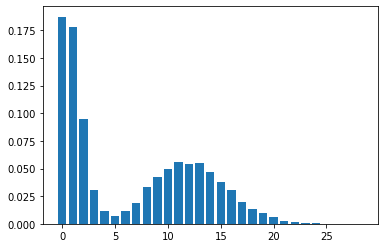

In [24]:
# check the function for my photon counts simulation funcion
t1 = time.time()
hist = rand_4Poisson_hist(0.5, 12, 0.5, 0.5, 0, repetitions=10000)
print("processing time new:", np.round( time.time()-t1, 4))

plt.hist(hist, bins=range(30), rwidth=0.8, align='left', density=True)
plt.show()

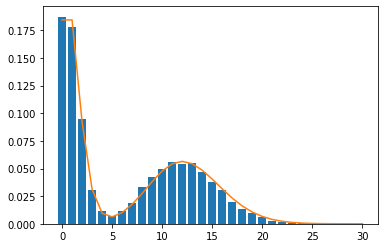

In [37]:
prefit = {'x': [24, 12.5, 1, 0, 0, 0]}

y_dd, y_du, y_uu,_,_,_ = eios_analyse.fit_hist_2I([hist], prefit, parallel = True)

ii = 0
plot_hist_res_2I(hist, prefit['x'][:3], [y_dd[ii], y_du[ii], y_uu[ii]])

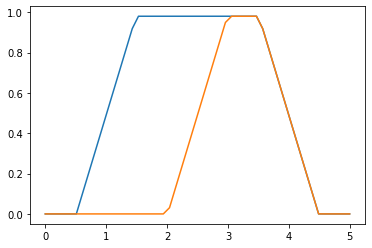

In [223]:
times = np.linspace(-0, 5, 50)

# define a simple ramp funciton
def rmp(t):
    if t <= 0.01:
        return 0.01
    elif 0.01<t<=0.99:
        return t
    else:
        return 0.99

Ps1 = np.array([rmp(t-0.5)-rmp(t-3.5) for t in times])
Ps2 = np.array([rmp(t - 2)-rmp(t-3.5) for t in times])

plt.plot(times, Ps1)
plt.plot(times, Ps2)
plt.show()

# simulate data
hists = []
for i, t in enumerate(times):
    hists.append([rand_4Poisson(0.5, 8, 0, Ps1[i], Ps2[i]) for j in range(100)])

In [226]:
# do the prefit to determine the three count levels (with all histograms)

t1 = time.time()
prefit = eios_analyse.fit_poisson_hist_2I(hists, 0.5, 10)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 0.2877


In [227]:
# do the fits to determine the population of (down, down) and (down, up) = (up, down) and (up, up)

t1 = time.time()
# y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)
y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = fit_hist_2I(hists, prefit, parallel = True)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 0.125


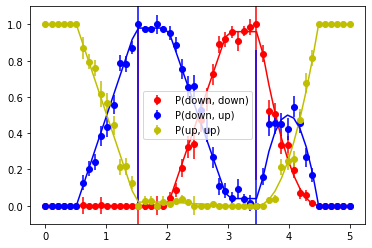

In [229]:
plt.errorbar(times, y_dd, y_err_dd, fmt = 'ro', label='P(down, down)')
plt.errorbar(times, y_du, y_err_du, fmt = 'bo', label='P(down, up)')
plt.errorbar(times, y_uu, y_err_uu, fmt = 'yo', label='P(up, up)')

# fit results
# plt.plot(times, y_dd, 'ro', label=r'P($\downarrow \downarrow$)')
# plt.plot(times, y_du, 'bo', label=r'P($\downarrow \uparrow$)')
# plt.plot(times, y_uu, 'yo', label=r'P($\uparrow \uparrow$)')

# expectation
plt.plot(times, Ps1*Ps2, 'r-') # both down
plt.plot(times, (1-Ps1)*Ps2 + Ps1*(1-Ps2), 'b-') # one down one up
plt.plot(times, (1-Ps1)*(1-Ps2), 'y-') # both up
plt.ylim((-0.1, 1.1))
plt.legend()
plt.show()

This plot shows the results of the fit routine to get the population levels P(down, down), P(up, up) and P(down, up)=P(up, down).<br/>
The dots show the fitted results, and the lines the expectation (e.g. the initial values for the data simulation). It was assumed that the simulated histogram can be fitted on a three-poissonian-distribution, but the data was simulated using a four-poissonian-distribution, with expectation values for the (down, up) state slightly different to the expectation value for the (up, down) state.

3.163265306122449
values: [0.91 0.09 0.  ]
errors: [0.055 0.055 0.005]


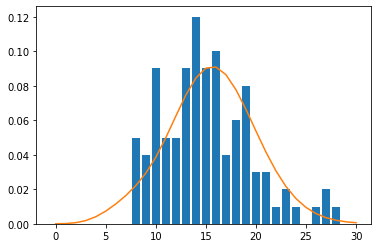

In [231]:
# plot one histogram with the fit
ii = 31

print(times[ii])

print('values:', np.round([y_dd[ii], y_du[ii], y_uu[ii]], 3))
print('errors:', np.round([y_err_dd[ii], y_err_du[ii], y_err_uu[ii]], 3))

plot_hist_res_2I(hists[ii], np.flip(np.sort(prefit['x'][:3])), [y_dd[ii], y_du[ii], y_uu[ii]])

In [232]:
# eios_analyse.fit_hist_2I([hists[ii]], prefit, parallel = True)
fit_hist_2I([hists[ii]], prefit, parallel = True)

([0.9096155035008657],
 [0.09038449586768427],
 [6.314499606104668e-10],
 [0.05507673243166431],
 [0.05485013178420267],
 [0.004990942073573097])

## simulate MW flop

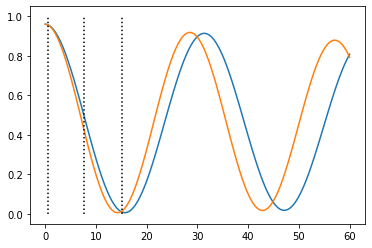

In [233]:
# simulate MW Flop
times = np.linspace(0, 60, 120)
iis = [1, 15, 30]

Ps1 = (0.48*(1+np.cos(0.2*times)) - 0.2) * np.exp(-0.002*times) + 0.2
Ps2 = (0.48*(1+np.cos(0.22*times)) - 0.21) * np.exp(-0.002*times) + 0.21

plt.plot(times, Ps1)
plt.plot(times, Ps2)
for ii in iis: plt.plot([times[ii], times[ii]], [0, 1], 'k:')
plt.show()

# simulate data
hists = []
for i, t in enumerate(times):
    hists.append([rand_4Poisson(0.5, 8, 0, Ps1[i], Ps2[i]) for j in range(1000)])

In [234]:
t1 = time.time()
prefit = eios_analyse.fit_poisson_hist_2I(hists, 0.5, 10)
print("processing time:", np.round( time.time()-t1, 4))

t1 = time.time()
y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = fit_hist_2I(hists, prefit, parallel = True)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 4.6918
processing time: 0.3987


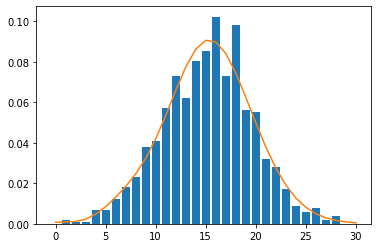

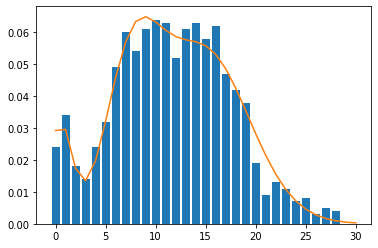

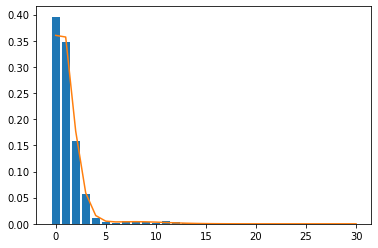

In [235]:
mus = np.flip(np.sort(prefit['x'][:3]))

for ii in [1, 10, 31]:
    plot_hist_res_2I(hists[ii], mus, [y_dd[ii], y_du[ii], y_uu[ii]])

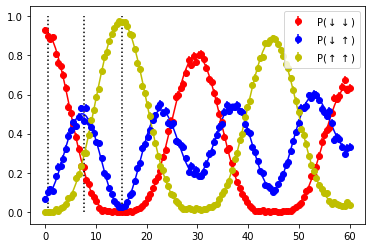

In [240]:
# fit results
plt.errorbar(times, y_dd, y_err_dd, fmt = 'ro', label=r'P($\downarrow \downarrow$)')
plt.errorbar(times, y_du, y_err_du, fmt = 'bo', label=r'P($\downarrow \uparrow$)')
plt.errorbar(times, y_uu, y_err_uu, fmt = 'yo', label=r'P($\uparrow \uparrow$)')

# expectation
plt.plot(times, Ps1*Ps2, 'r-') # both down
plt.plot(times, (1-Ps1)*Ps2 + Ps1*(1-Ps2), 'b-') # one down one up
plt.plot(times, (1-Ps1)*(1-Ps2), 'y-') # both up

for ii in iis: plt.plot([times[ii], times[ii]], [0, 1], 'k:')
plt.legend()
plt.show()